In [207]:
import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata, interp2d
import pickle
import os


import astropy as ap
from astropy.io import fits
from astropy import table as t
from astropy.table import Table
from astropy import wcs
from astropy.cosmology import WMAP7

import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors
from matplotlib.colors import LogNorm

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 1

In [208]:
os.chdir("/Users/nitya/Work/data/Project2")
drpall = t.Table.read('drpall-v2_5_3.fits')
print(len(drpall))
drpall.add_index('plateifu')
index1 = np.where(drpall['srvymode']=='MaNGA dither')[0]
drpall1 = drpall[index1]
index2 = np.where(drpall1['z']>0)[0]
drpall = drpall1[index2]
index3 = np.where(drpall['nsa_z']>0)[0]
drpall = drpall[index3]

#print(drpall.columns)
print(len(drpall))

a = pickle.load(open(r'manga_4000_hdelta_dn4000.pkl','rb'), encoding = 'latin1')
a = a[index3]
print(a.dtype.names)

d1 = pickle.load(open(r'shifted_z_0.02','rb'), encoding = 'latin1') 
d2 = pickle.load(open(r'shifted_z_0.04','rb'), encoding = 'latin1')
d3 = pickle.load(open(r'shifted_z_0.06','rb'), encoding = 'latin1')
d4a = pickle.load(open(r'shifted_z_0.08','rb'), encoding = 'latin1')
d5 = pickle.load(open(r'shifted_z_0.1','rb'), encoding = 'latin1')
d6 = pickle.load(open(r'shifted_z_0.14','rb'), encoding = 'latin1')

6779
6468
('plate_ifu', 'z', 'hdelta_all', 'hdelta_3', 'hdelta_5', 'hdelta_7', 'dn4000_all', 'dn4000_3', 'dn4000_5', 'dn4000_7')


In [209]:
df = pd.read_csv('hd_d4000_mlratio_z.csv')
df.head()

,Unnamed: 0,specObjID,plateid_x,mjd_x,targettype_x,z_x,ra_x,dec_x,spectrotype_x,lick_hd_a,...,spectrotype_y,psfFlux_z,fiberFlux_z,modelMag_z,fiberMag_z,petroMag_z,psfMag_z,cModelMag_z,zband_lum,mlratio_z
0,1288098,571978357969807360,508,52366,GALAXY,0.065824,166.4783,2.094602,GALAXY,2.151605,...,GALAXY,28.06302,33.45266,16.86503,18.68839,16.92087,18.87891,16.92317,9.759862,0.189329
1,400208,1562851102729201664,1388,53119,GALAXY,0.111108,232.1581,32.259860,GALAXY,2.135609,...,GALAXY,68.12619,89.96645,15.89000,17.61473,15.95821,17.91659,15.79503,10.615238,0.347252
2,590268,2187701916006377472,1943,53386,GALAXY,0.061661,142.9699,32.348130,GALAXY,3.941239,...,GALAXY,42.61896,50.59392,17.25803,18.23952,17.33761,18.42566,17.28630,9.512923,0.006772
3,989578,487552899115673600,433,51873,GALAXY,0.106914,116.2391,37.233990,GALAXY,2.766207,...,GALAXY,26.55329,39.21035,16.65694,18.51611,16.68685,18.93886,16.56544,10.268623,-0.021323
4,169894,1130466224317163520,1004,52723,GALAXY,0.045666,167.0256,6.661255,GALAXY,2.404512,...,GALAXY,66.11886,75.75258,16.86960,17.80140,16.82482,17.94905,16.68491,9.409395,0.201458


In [180]:
mlz_model = df['mlratio_z'].values
hda_model = df['lick_hd_a'].values
d4_model = df['d4000_n'].values
model_grid = np.column_stack((np.array(d4_model), np.array(hda_model)))


#Retaining the binning for SDSS data for later plots
m = binned_statistic_2d(df['d4000_n'], df['lick_hd_a'], 
                         df['mlratio_z'],statistic = 'count',bins=(50,50))
ybins = np.array(m[1])
xbins = np.array(m[2])

In [197]:
def all_measures(array,z):
    
    hd = np.array([array[i][2][0] for i in range(len(array))])
    d4 = np.array([array[i][2][1] for i in range(len(array))])
    b = a[~np.isnan(hd)]
    hd_all = b['hdelta_all']
    b = b[hd_all>-10]
    print(len(b), len(hd), len(d4))
    #at that redshift
    hd_z = hd[~np.isnan(hd)][hd_all>-10]
    d4_z = d4[~np.isnan(hd)][hd_all>-10]
    print(len(d4_z), len(hd_z))
    d4_z = d4_z[hd_z>-10]
    b = b[hd_z>-10]
    hd_z = hd_z[hd_z>-10]
    
    #Offsets
    offz_d4 = np.array([b['dn4000_all'][i]- d4_z[i] for i in range(len(d4_z))])
    offz_hd = np.array([b['hdelta_all'][i]- hd_z[i] for i in range(len(d4_z))])
    
    #Interpolating to get the M/L ratios at z and the total M/L ratios
    points_z = np.column_stack((d4_z,hd_z))
    points_all = np.column_stack((b['dn4000_all'], b['hdelta_all']))
    mlz_z = griddata(model_grid,np.array(mlz_model),points_z, method = 'nearest')
    mlz_all = griddata(model_grid,np.array(mlz_model),points_all, method = 'nearest')
    mlz_offset = np.array([mlz_all[i]- mlz_z[i] for i in range(len(mlz_z))])

    #Make a pandas dataframe and write to it
    data = {'plate_ifu': b['plate_ifu'], 'z': b['z'], 
            'hd_z': hd_z, 'd4_z': d4_z,
            'hd_all': b['hdelta_all'], 'd4_all': b['dn4000_all'], 
            'offset_hd': offz_hd, 'offset_d4': offz_d4, 
            'mlz_z': mlz_z, 'mlz_all': mlz_all, 'offset_mlz': mlz_offset
            }
    d = pd.DataFrame(data=data)
    filepath = '/Users/nitya/Work/data/Project2/offset_mlratio_nearest_nonmodel_'+str(z)+'.csv'
    d.to_csv(filepath)
    
    return d

In [198]:
p1 = all_measures(d1,0.02)
p2 = all_measures(d3,0.06)
p3 = all_measures(d6,0.14)

561 6468 6468
561 561
5016 6468 6468
5016 5016
6402 6468 6468
6402 6402


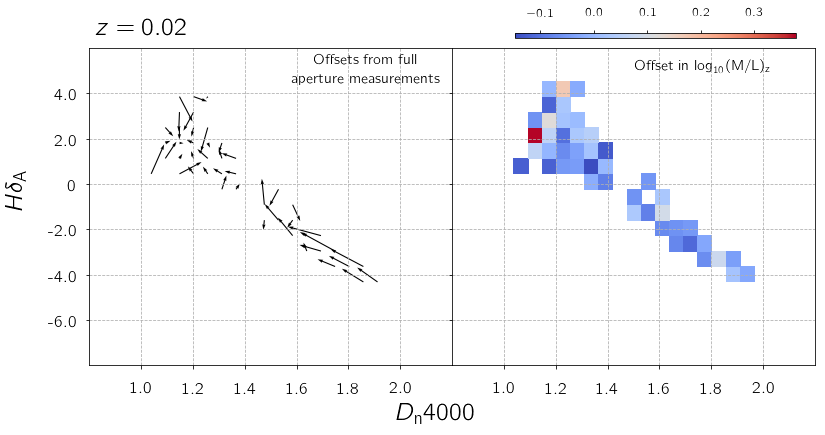

In [199]:
tcount = binned_statistic_2d(p1['d4_z'],p1['hd_z'],p1['z'],
                             statistic = 'count',bins=(20,20))
hdoff = binned_statistic_2d(p1['d4_z'],p1['hd_z'],p1['offset_hd'],
                            statistic = 'mean',bins=(20,20))
d4off = binned_statistic_2d(p1['d4_z'],p1['hd_z'],p1['offset_d4'],
                            statistic = 'mean',bins=(20,20))
t1 = binned_statistic_2d(p1['d4_z'], p1['hd_z'],p1['offset_mlz'],
                         statistic = 'mean',bins=(20,20))

yedges = [0.5*(tcount[1][i] + tcount[1][i+1]) for i in range(20)]
xedges = [0.5*(tcount[2][i] + tcount[2][i+1]) for i in range(20)]

hd_offset = np.ma.array(hdoff[0], mask = tcount[0] <= 3)
d4_offset = np.ma.array(d4off[0], mask = tcount[0] <= 3)
number = np.ma.array(tcount[0], mask = tcount[0] <= 3)
ml = np.ma.array(t1[0], mask = tcount[0] <= 3)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,7))

#cs1 = ax1.pcolormesh(yedges1,xedges1,np.transpose(number), cmap = plt.cm.Greys_r, norm = LogNorm())
q = ax1.quiver(yedges, xedges, np.transpose(d4_offset), np.transpose(hd_offset), 
              angles = 'xy', scale = 1., scale_units = 'xy')

ax1.grid(linestyle = '--')
ax1.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax1.set_yticks([-4.0,-2.0,0,2.0,4.0,6.0])
ax1.yaxis.set_ticklabels([-6.0,-4.0,-2.0,0,2.0,4.0,6.0])
ax1.set_xlim(0.8,2.2)
ax1.set_ylim(-6.0,8.0)

cs2 = ax2.pcolormesh(yedges,xedges,np.transpose(ml), cmap = plt.cm.coolwarm)
ax2.grid(linestyle = '--')
ax2.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax2.set_yticks([-4.0,-2.0,0,2.0,4.0,6.0])
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0.8,2.2)
ax2.set_ylim(-6.0,8.0)

#cbar_ax1 = fig.add_axes([0.14, 0.85, 0.3, 0.01])
#cb1 = fig.colorbar(cs1,orientation = 'horizontal', cax=cbar_ax1)
#cb1.ax.xaxis.set_ticks_position('top')
#cb1.ax.tick_params(labelsize=13)
cbar_ax2 = fig.add_axes([0.58, 0.85, 0.3, 0.01])
cb2 = fig.colorbar(cs2,orientation = 'horizontal', cax=cbar_ax2)
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.tick_params(labelsize=13)

fig.text(0.78, 0.79, r'Offset in ${\rm log}_{10}(\rm M/L)_{z}$',
         ha='center', va='center', fontsize = 15)
fig.text(0.42, 0.79, 'Offsets from full \n aperture measurements',
         ha='center', va='center', fontsize = 15)
fig.text(0.18, 0.87, r'$z=0.02$',
         ha='center', va='center', fontsize = 25)
fig.text(0.495, 0.1, r'$D_{\rm n}4000$', 
         ha='center', va='center', fontsize = 25)
fig.text(0.05, 0.55, r'$H\delta_{\rm A}$', 
          rotation=90, ha='center', va='center', fontsize = 25)

plt.gcf().subplots_adjust(wspace=0, hspace = 0, top = 0.83, bottom = 0.2)
plt.savefig('/Users/Nitya/Desktop/mlz_offset_0.02.pdf')
plt.show()

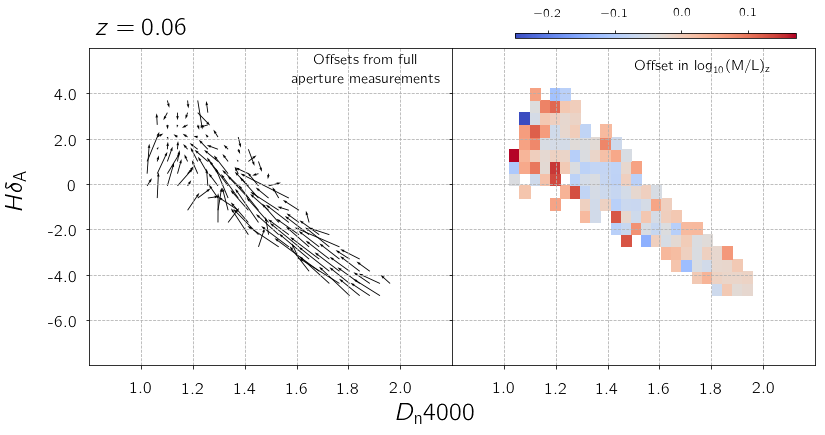

In [200]:
tcount = binned_statistic_2d(p2['d4_z'],p2['hd_z'],p2['z'],
                             statistic = 'count',bins=(30,30))
hdoff = binned_statistic_2d(p2['d4_z'],p2['hd_z'],p2['offset_hd'],
                            statistic = 'mean',bins=(30,30))
d4off = binned_statistic_2d(p2['d4_z'],p2['hd_z'],p2['offset_d4'],
                            statistic = 'mean',bins=(30,30))
t1 = binned_statistic_2d(p2['d4_z'], p2['hd_z'],p2['offset_mlz'],
                         statistic = 'mean',bins=(30,30))

yedges = [0.5*(tcount[1][i] + tcount[1][i+1]) for i in range(30)]
xedges = [0.5*(tcount[2][i] + tcount[2][i+1]) for i in range(30)]

hd_offset = np.ma.array(hdoff[0], mask = tcount[0] <= 3)
d4_offset = np.ma.array(d4off[0], mask = tcount[0] <= 3)
number = np.ma.array(tcount[0], mask = tcount[0] <= 3)
ml = np.ma.array(t1[0], mask = tcount[0] <= 3)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,7))

#cs1 = ax1.pcolormesh(yedges1,xedges1,np.transpose(number), cmap = plt.cm.Greys_r, norm = LogNorm())
q = ax1.quiver(yedges, xedges, np.transpose(d4_offset), np.transpose(hd_offset), 
              angles = 'xy', scale = 1., scale_units = 'xy')

ax1.grid(linestyle = '--')
ax1.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax1.set_yticks([-4.0,-2.0,0,2.0,4.0,6.0])
ax1.yaxis.set_ticklabels([-6.0,-4.0,-2.0,0,2.0,4.0,6.0])
ax1.set_xlim(0.8,2.2)
ax1.set_ylim(-6.0,8.0)

cs2 = ax2.pcolormesh(yedges,xedges,np.transpose(ml), cmap = plt.cm.coolwarm)
ax2.grid(linestyle = '--')
ax2.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax2.set_yticks([-4.0,-2.0,0,2.0,4.0,6.0])
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0.8,2.2)
ax2.set_ylim(-6.0,8.0)

cbar_ax2 = fig.add_axes([0.58, 0.85, 0.3, 0.01])
cb2 = fig.colorbar(cs2,orientation = 'horizontal', cax=cbar_ax2)
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.tick_params(labelsize=13)

fig.text(0.78, 0.79, r'Offset in ${\rm log}_{10}(\rm M/L)_{z}$',
         ha='center', va='center', fontsize = 15)
fig.text(0.42, 0.79, 'Offsets from full \n aperture measurements',
         ha='center', va='center', fontsize = 15)
fig.text(0.18, 0.87, r'$z=0.06$',
         ha='center', va='center', fontsize = 25)
fig.text(0.495, 0.1, r'$D_{\rm n}4000$', 
         ha='center', va='center', fontsize = 25)
fig.text(0.05, 0.55, r'$H\delta_{\rm A}$', 
          rotation=90, ha='center', va='center', fontsize = 25)

plt.gcf().subplots_adjust(wspace=0, hspace = 0, top = 0.83, bottom = 0.2)
plt.savefig('/Users/Nitya/Desktop/mlz_offset_0.06.pdf')
plt.show()

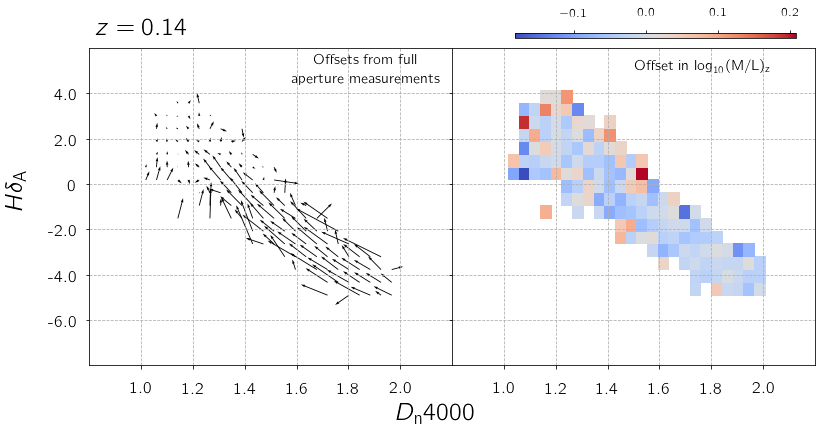

In [201]:
tcount = binned_statistic_2d(p3['d4_z'],p3['hd_z'],p3['z'],
                             statistic = 'count',bins=(30,30))
hdoff = binned_statistic_2d(p3['d4_z'],p3['hd_z'],p3['offset_hd'],
                            statistic = 'mean',bins=(30,30))
d4off = binned_statistic_2d(p3['d4_z'],p3['hd_z'],p3['offset_d4'],
                            statistic = 'mean',bins=(30,30))
t1 = binned_statistic_2d(p3['d4_z'], p3['hd_z'],p3['offset_mlz'],
                         statistic = 'mean',bins=(30,30))

yedges = [0.5*(tcount[1][i] + tcount[1][i+1]) for i in range(30)]
xedges = [0.5*(tcount[2][i] + tcount[2][i+1]) for i in range(30)]

hd_offset = np.ma.array(hdoff[0], mask = tcount[0] <= 3)
d4_offset = np.ma.array(d4off[0], mask = tcount[0] <= 3)
number = np.ma.array(tcount[0], mask = tcount[0] <= 3)
ml = np.ma.array(t1[0], mask = tcount[0] <= 3)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,7))

#cs1 = ax1.pcolormesh(yedges1,xedges1,np.transpose(number), cmap = plt.cm.Greys_r, norm = LogNorm())
q = ax1.quiver(yedges, xedges, np.transpose(d4_offset), np.transpose(hd_offset), 
              angles = 'xy', scale = 1., scale_units = 'xy')

ax1.grid(linestyle = '--')
ax1.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax1.set_yticks([-4.0,-2.0,0,2.0,4.0,6.0])
ax1.yaxis.set_ticklabels([-6.0,-4.0,-2.0,0,2.0,4.0,6.0])
ax1.set_xlim(0.8,2.2)
ax1.set_ylim(-6.0,8.0)

cs2 = ax2.pcolormesh(yedges,xedges,np.transpose(ml), cmap = plt.cm.coolwarm)
ax2.grid(linestyle = '--')
ax2.set_xticks([1.0,1.2,1.4,1.6,1.8,2.0])
ax2.set_yticks([-4.0,-2.0,0,2.0,4.0,6.0])
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0.8,2.2)
ax2.set_ylim(-6.0,8.0)

#cbar_ax1 = fig.add_axes([0.14, 0.85, 0.3, 0.01])
#cb1 = fig.colorbar(cs1,orientation = 'horizontal', cax=cbar_ax1)
#cb1.ax.xaxis.set_ticks_position('top')
#cb1.ax.tick_params(labelsize=13)
cbar_ax2 = fig.add_axes([0.58, 0.85, 0.3, 0.01])
cb2 = fig.colorbar(cs2,orientation = 'horizontal', cax=cbar_ax2)
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.tick_params(labelsize=13)

fig.text(0.78, 0.79, r'Offset in ${\rm log}_{10}(\rm M/L)_{z}$',
         ha='center', va='center', fontsize = 15)
fig.text(0.42, 0.79, 'Offsets from full \n aperture measurements',
         ha='center', va='center', fontsize = 15)
fig.text(0.18, 0.87, r'$z=0.14$',
         ha='center', va='center', fontsize = 25)
fig.text(0.495, 0.1, r'$D_{\rm n}4000$', 
         ha='center', va='center', fontsize = 25)
fig.text(0.05, 0.55, r'$H\delta_{\rm A}$', 
          rotation=90, ha='center', va='center', fontsize = 25)

plt.gcf().subplots_adjust(wspace=0, hspace = 0, top = 0.83, bottom = 0.2)
plt.savefig('/Users/Nitya/Desktop/mlz_offset_0.14.pdf')
plt.show()


In [227]:
df = pd.read_csv('hd_d4000_mlratio_z.csv')
df.head()

,Unnamed: 0,specObjID,plateid_x,mjd_x,targettype_x,z_x,ra_x,dec_x,spectrotype_x,lick_hd_a,...,spectrotype_y,psfFlux_z,fiberFlux_z,modelMag_z,fiberMag_z,petroMag_z,psfMag_z,cModelMag_z,zband_lum,mlratio_z
0,1288098,571978357969807360,508,52366,GALAXY,0.065824,166.4783,2.094602,GALAXY,2.151605,...,GALAXY,28.06302,33.45266,16.86503,18.68839,16.92087,18.87891,16.92317,9.759862,0.189329
1,400208,1562851102729201664,1388,53119,GALAXY,0.111108,232.1581,32.259860,GALAXY,2.135609,...,GALAXY,68.12619,89.96645,15.89000,17.61473,15.95821,17.91659,15.79503,10.615238,0.347252
2,590268,2187701916006377472,1943,53386,GALAXY,0.061661,142.9699,32.348130,GALAXY,3.941239,...,GALAXY,42.61896,50.59392,17.25803,18.23952,17.33761,18.42566,17.28630,9.512923,0.006772
3,989578,487552899115673600,433,51873,GALAXY,0.106914,116.2391,37.233990,GALAXY,2.766207,...,GALAXY,26.55329,39.21035,16.65694,18.51611,16.68685,18.93886,16.56544,10.268623,-0.021323
4,169894,1130466224317163520,1004,52723,GALAXY,0.045666,167.0256,6.661255,GALAXY,2.404512,...,GALAXY,66.11886,75.75258,16.86960,17.80140,16.82482,17.94905,16.68491,9.409395,0.201458


In [228]:
df = df[df['lick_hd_a']>-10][df['lick_hd_a']<=12]
df = df[df['d4000_n']>0.5][df['lick_hd_a']<=12]
print(len(df))

/Users/nitya/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


735808


In [230]:
print(min(df['lick_hd_a']), max(df['lick_hd_a']), min(df['d4000_n']), max(df['d4000_n']))
df = df[df['d4000_n']<2.5]
print(len(df))

-9.998553 11.98128 0.5038382 2.9992259999999997
735556


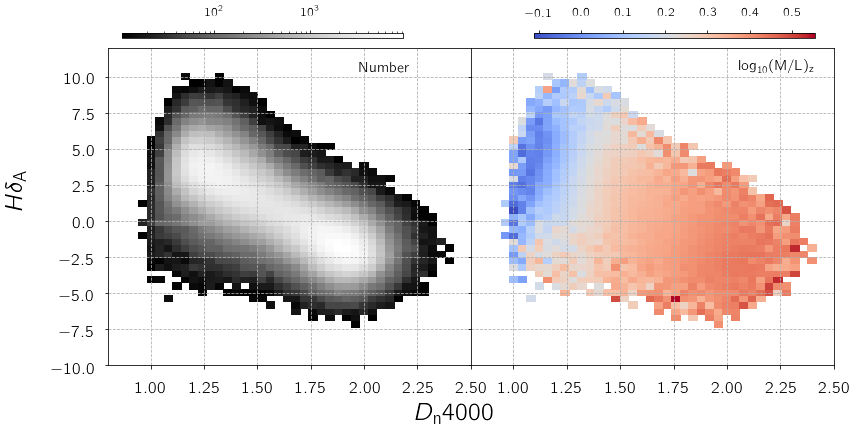

In [234]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13,7))
t1 = binned_statistic_2d(df['d4000_n'], df['lick_hd_a'],
                         df['mlratio_z'],statistic = 'mean',bins=(50,50))

yedges1 = t1[1]
xedges1 = t1[2]
tcount = binned_statistic_2d(df['d4000_n'], df['lick_hd_a'],
                             df['mlratio_z'],statistic = 'count',bins=(yedges1,xedges1))

number = np.ma.array(tcount[0], mask = tcount[0] <= 10)
mass = np.ma.array(t1[0], mask = tcount[0] <= 10)

cs1 = ax1.pcolormesh(yedges1,xedges1,np.transpose(number), cmap = plt.cm.Greys_r, norm = LogNorm())
ax1.grid(linestyle = '--')
ax1.set_xlim(0.8,2.5)
ax1.set_ylim(-10,12)
#ax1.xaxis.set_ticklabels([1,1.25,1.5,2,2.25])

cs2 = ax2.pcolormesh(yedges1,xedges1,(np.transpose(mass)), cmap = plt.cm.coolwarm)
ax2.grid(linestyle = '--')
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0.8,2.5)
ax2.set_ylim(-10,12)

cbar_ax1 = fig.add_axes([0.14, 0.85, 0.3, 0.01])
cb1 = fig.colorbar(cs1,orientation = 'horizontal', cax=cbar_ax1)
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=13)
cbar_ax2 = fig.add_axes([0.58, 0.85, 0.3, 0.01])
cb2 = fig.colorbar(cs2,orientation = 'horizontal', cax=cbar_ax2)
cb2.ax.xaxis.set_ticks_position('top')
cb2.ax.tick_params(labelsize=13)

fig.text(0.84, 0.79, r'${\rm log}_{10}(\rm M/L)_{z}$',
         ha='center', va='center', fontsize = 15)
fig.text(0.42, 0.79, 'Number',
         ha='center', va='center', fontsize = 15)
fig.text(0.495, 0.1, r'$D_{\rm n}4000$', 
         ha='center', va='center', fontsize = 25)
fig.text(0.03, 0.55, r'$H\delta_{\rm A}$', 
          rotation=90, ha='center', va='center', fontsize = 25)

plt.gcf().subplots_adjust(wspace=0, hspace = 0, top = 0.83, bottom = 0.2)
plt.savefig('/Users/Nitya/Desktop/hd_d4000_mlratio_coarser_binning.pdf')
plt.show()

In [190]:
print(len(p1), len(p2), len(p3), len(df), len(a))
print(np.min(p3['hd_z']), np.max(p3['hd_z']), np.min(p3['d4_z']), np.max(p3['d4_z']))

561 5016 6402 735915 6468
-17.249787179624345 6.97280890943296 0.6722680841711052 2.0288584457698104


In [ ]:
p3['hd_z'].hist()

In [ ]:
p3[~np.isnan(p3['hd_z'].values)]

In [ ]:
p3[p3['d4_z']]